In [1]:
import random
from tqdm.autonotebook import tqdm

/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
import pandas as pd
import numpy as np
import pycm

from xgboost import XGBClassifier
from sklearn import metrics as skmetrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import label_binarize, QuantileTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import logging

In [3]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [4]:
df = pd.read_parquet("./dataset.parquet")\
    .dropna(subset=['month_purchase'])

df.loc[:, 'not_same_day'] = (
    (df.loc[:, 'has_second_sale_within_year'] == 1) & 
    (df.loc[:, 'waiting_time'] > 0)
)

df = df.loc[df.not_same_day == 1]

categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']
feature_columns = [
    'channel', 'partner', 'device', 'age', 'gender', 'state', 'has_marketplace', 
    'has_crossdocking', 'has_private_label', 'has_brands', 'gmv', 'fst_sale_in_black_friday_days', 
    'snd_sale_in_black_friday_days'
]

In [5]:
periods = [0, 30, 90, 180, 365]
labels = ["first_month", "first_quarter", "first_semester", "this_year"]

# periods = [0, 30, 365]
# labels = ["first_month", "this_year"]

In [6]:
df.loc[:, 'period'] = pd.cut(df.waiting_time, periods, include_lowest=True, labels=labels)
code2period = df.period.groupby(df.period.cat.codes).aggregate("first")
df.period.value_counts(dropna=False)

first_month       131848
first_quarter      88642
first_semester     60053
this_year          30847
Name: period, dtype: int64

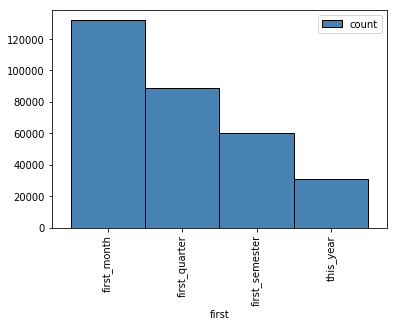

In [7]:
target_distribution = df.period.groupby(df.period.cat.codes).aggregate(["first", "count"])

target_distribution.plot\
    .bar(x="first", y="count", color='SteelBlue', width=1, edgecolor='black')

In [8]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [ ]:
features = [c for c in df.columns if any([c.startswith(x) for x in feature_columns])]
X = df.loc[:, features]
y = df.loc[:, 'period'].cat.codes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

qt = QuantileTransformer()
qt.fit(X_train.loc[:, ["age", "gmv"]])

X_train.loc[:, ["age", "gmv"]] = qt.transform(X_train.loc[:, ["age", "gmv"]])
X_test.loc[:, ["age", "gmv"]] = qt.transform(X_test.loc[:, ["age", "gmv"]])

/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
target_distribution = y_train.value_counts(normalize=True)
inverse_target_distribution = target_distribution.max() / target_distribution
inverse_target_distribution.to_dict()

{0: 1.0, 1: 1.4954541042482286, 2: 2.1917158640965457, 3: 4.2911521678581375}

In [ ]:
HYPERPARAMETER_SPACE = [
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 1.0, "uniform", name='learning_rate'),
    Real(0.1, 10, "log-uniform", name='gamma'),    
    Real(0.05, 1, name='subsample'),
    Real(0.05, 1, name='colsample_bytree'),
#     Integer(2, 6, name='max_depth'),
#     Integer(100, 200, name="n_estimators"),
    Real(0.01, 0.99, name="base_score"),
    Real(0.25, 3.0, name="scale_pos_weight"),
    Real(0, 5, name="reg_alpha"),
    Real(0, 5, name="reg_lambda"),
]

HYPERPARAMETER_NAMES = [dim.name for dim in HYPERPARAMETER_SPACE]

In [ ]:
RANDOM_STATE = 939568576
TREE_METHOD = 'hist'#'exact'
NUM_PROCESSORS = 8
NUM_CROSS_VALIDATION_STEPS = 5
NUM_GP_OPTIMIZATION_STEPS = 100

In [ ]:
def get_logger(name):
    logger = logging.getLogger(name)
    formatter = logging.Formatter('[%(asctime)s] %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)
    return logger

logger = get_logger(__name__)

In [ ]:
def train_model(X, y, **kwargs):
    model = CalibratedClassifierCV(
        XGBClassifier(
            max_depth=2,
            n_estimators=100,
            random_state=RANDOM_STATE,
            tree_method=TREE_METHOD,
            n_jobs=NUM_PROCESSORS,
            **kwargs,
        ),
        cv=5
    )
    model.fit(X, y)
    return model

def evaluate_model(X, y, **kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.2)
    model = train_model(X_train, y_train, **kwargs)
    score = model.predict_proba(X_test)
    log_like = np.log(score[range(y_test.size), y_test]).mean()
    logger.info(f"Values: {log_like}")
    return log_like


def train_optimized_model(X, y):
        
    @use_named_args(HYPERPARAMETER_SPACE)
    def loss(**kwargs):
        return -evaluate_model(X, y, **kwargs)

    def get_optimization_callback():
        message = "Hyperparameter optimization iteration {:d}/{:d}. Current: {:5.3f}. Best: {:5.3f}."
            #" Parameters:\n{}"
        def callback(res):          
            current_value = -res.func_vals[-1]
            best_value = -res.func_vals.min()            
            current_params = pd.Series(dict(zip(
                HYPERPARAMETER_NAMES, 
                map(fix_type, res.x)
            )))
            logger.info(message.format(
                len(res.func_vals),
                NUM_GP_OPTIMIZATION_STEPS,
                current_value,
                best_value,
                #current_params
            ))

        return callback

    def fix_type(x):
        if isinstance(x, bool):
            return x
        elif np.issubdtype(np.dtype(x), np.int_):
            return int(x)
        elif np.issubdtype(np.dtype(x), np.float_):
            return float(x)

    logger.info("Will start hyperparameter optimization.")
    optimization_results = gp_minimize(
        loss,
        HYPERPARAMETER_SPACE,
        n_random_starts=max(1, min(10, int(NUM_GP_OPTIMIZATION_STEPS / 2))),
        n_calls=NUM_GP_OPTIMIZATION_STEPS,
        random_state=RANDOM_STATE,
        callback=get_optimization_callback(),
    )
    logger.info("Finished hyperparameter optimization.")
    best_parameters = dict(
        zip(HYPERPARAMETER_NAMES, map(fix_type, optimization_results.x))
    )
    logger.info("Starting training of final model.")
    return train_model(X, y, verbosity=1, calibrated=True, **best_parameters)


In [ ]:
%time best_model = train_optimized_model(X_train, y_train)

[2019-04-26 17:20:33,627] Will start hyperparameter optimization.
[2019-04-26 17:20:54,876] Values: -1.2305001872643566
[2019-04-26 17:20:54,879] Hyperparameter optimization iteration 1/100. Current: -1.231. Best: -1.231.
[2019-04-26 17:21:14,211] Values: -1.2307155061477326
[2019-04-26 17:21:14,226] Hyperparameter optimization iteration 2/100. Current: -1.231. Best: -1.231.
[2019-04-26 17:21:38,723] Values: -1.2275143047561987
[2019-04-26 17:21:38,726] Hyperparameter optimization iteration 3/100. Current: -1.228. Best: -1.228.
[2019-04-26 17:21:56,745] Values: -1.229115179686999
[2019-04-26 17:21:56,748] Hyperparameter optimization iteration 4/100. Current: -1.229. Best: -1.228.
[2019-04-26 17:22:18,026] Values: -1.2287471511415051
[2019-04-26 17:22:18,029] Hyperparameter optimization iteration 5/100. Current: -1.229. Best: -1.228.
[2019-04-26 17:22:34,657] Values: -1.2294935160487905
[2019-04-26 17:22:34,660] Hyperparameter optimization iteration 6/100. Current: -1.229. Best: -1.228.

In [ ]:
y_pred = best_model.predict(X_test)
s_pred = best_model.predict_proba(X_test)

print(skmetrics.classification_report(
    y_test,
    y_pred,
    labels=code2period.apply(str).index,
    target_names=code2period.apply(str).values
))

In [ ]:
cm = pycm.ConfusionMatrix(actual_vector=y_test.values, predict_vector=y_pred)

In [ ]:
cm.print_normalized_matrix()

In [ ]:
total_correlation = np.sqrt(1 - np.exp(-2 * mutual_info_classif(s_pred, y_test))).min()
print(total_correlation)

In [ ]:
skmetrics.roc_auc_score(label_binarize(y_test, range(len(code2period))), s_pred, average='micro')

In [ ]:
skmetrics.roc_auc_score(label_binarize(y_test, range(len(code2period))), s_pred, average='macro')

In [ ]:
roc_curves = {
    code: {
        'auc': skmetrics.roc_auc_score(y_test == code, s_pred[:, code]),
        'curve': dict(zip(
            ['fpr', 'tpr', 'thres'],
            skmetrics.roc_curve(y_test == code, s_pred[:, code])
        ))
    }
    for code, _ in code2period.iteritems()
}

In [ ]:
n_rows = len(code2period)
fig = plt.figure(figsize=(12, 3 * n_rows))
main_gs = fig.add_gridspec(n_rows, 1)

for code, period in code2period.iteritems():
    row_gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=main_gs[code], height_ratios=(1, 400))
    
    ax_title = fig.add_subplot(row_gs[0, 0:2], frameon=False)
    ax_title.set_title(f"Label {period}", fontdict={'size': 13})
    ax_title.xaxis.set_visible(False)
    ax_title.yaxis.set_visible(False)
    
    axl = fig.add_subplot(row_gs[1, 0])
    axl.set_title("ROC Curve", fontdict={'size': 12})
    axl.plot(
        roc_curves[code]['curve']['fpr'],
        roc_curves[code]['curve']['tpr'], 
        label=f"AUC = {roc_curves[code]['auc']:5.2f}"
    )
    axl.legend()
    
    axr = fig.add_subplot(row_gs[1, 1])
    axr.set_title(f"Rates", fontdict={'size': 12})
    axr.plot(
        roc_curves[code]['curve']['thres'],
        roc_curves[code]['curve']['tpr'],
        label="True Positive Rate"
    )
    axr.plot(
        roc_curves[code]['curve']['thres'],
        roc_curves[code]['curve']['fpr'],
        label="False Positive Rate"
    )
    axr.legend()
    axr.set_xlim(0, 1)
    
    
fig.tight_layout()

In [ ]:
thresholds = np.linspace(0, 1, 101)
metric_names = ["precision", "recall", "f1", "ratio", "prec_full", "recall_full", "f1_full"]
columns = pd.MultiIndex.from_product(([code2period.index, metric_names]), names=["period", "metric"])
metrics = pd.DataFrame(index=thresholds, columns=columns, dtype=np.float)

In [ ]:
print(
    f"{'PERIOD':5s}\t\t"
    f"{'AUC S':5s}\t"
    f"{'AUC F':5s}\t"
    f"{'PRC S':5s}\t"
    f"{'REC S':5s}\t"
    f"{'F1 S':5s}\t"
    f"{'PRC F':5s}\t"
    f"{'REC F':5s}\t"
    f"{'F1 F':5s}\t"
)

for code, period in code2period.iteritems():    
    try:
        curr_y = y_test[y_test >= code]
        curr_s = s_pred[y_test >= code, code:]
        curr_p = curr_s[:, 0] / curr_s.sum(axis=1)
        
        for threshold in thresholds:
            prec, recall, f1, _ = skmetrics.precision_recall_fscore_support(
                curr_y == code, 
                (curr_p >= threshold),
                average='binary',
                warn_for=()
            )
            prec_full, recall_full, f1_full, _ = skmetrics.precision_recall_fscore_support(
                y_test == code, 
                (s_pred[:, code] >= threshold),
                average='binary',
                warn_for=()
            )            
            ratio = (curr_y == code)[curr_p > threshold].mean()
            metrics.loc[threshold, (code, metric_names)] = np.array([
                prec, recall, f1, ratio, prec_full, recall_full, f1_full
            ], dtype=np.float)
        best_threshold = metrics.loc[:, (code, 'f1')].idxmax()
        best_threshold_full = metrics.loc[:, (code, 'f1_full')].idxmax()
        y_pred = curr_p > best_threshold
        y_pred_full = s_pred[:, code] > best_threshold_full
        prec, recall, f1, _ = skmetrics.precision_recall_fscore_support(curr_y == code, y_pred, average='binary')
        prec_full, recall_full, f1_full, _ = skmetrics.precision_recall_fscore_support(
            y_test == code, y_pred_full, average='binary')
        print(
            f"{period:5s}\t"
            f"{skmetrics.roc_auc_score(curr_y == code, curr_p):5.3f}\t"
            f"{skmetrics.roc_auc_score(y_test == code, s_pred[:, code]):5.3f}\t"
            f"{prec:5.3}\t"
            f"{recall:5.3}\t"
            f"{f1:5.3}\t"
            f"{prec_full:5.3}\t"
            f"{recall_full:5.3}\t"
            f"{f1_full:5.3}\t"
        )
    except ValueError:
        print(
            f"{period:5s}\t"
            f"{'  -  ':5s}\t"
            f"{skmetrics.roc_auc_score(y_test == code, s_pred[:, code]):5.3f}\t"
            f"{1.0:5.3F}\t"
            f"{1.0:5.3F}\t"
            f"{1.0:5.3F}\t"
            f"{prec_full:5.3}\t"
            f"{recall_full:5.3}\t"
            f"{f1_full:5.3}\t"            
        )

In [ ]:
pd.value_counts(s_pred[:, 0], bins=np.linspace(0, 1, 21)).plot()

In [ ]:
n_rows = len(code2period)
fig = plt.figure(figsize=(12, 3 * n_rows))

for code, period in code2period.iteritems():
    best_threshold = metrics.loc[:, (code, 'f1')].idxmax()
    
    ax = fig.add_subplot(n_rows, 1, code + 1)
    ax.set_title(f"Precision, Recall and F_1 - {period}", fontdict={'size': 12})
    ax.plot(
        metrics.index,
        metrics.loc[:, (code, 'precision')],
        label="Precision"
    )
    ax.plot(
        metrics.index,
        metrics.loc[:, (code, 'recall')],
        label="Recall"
    )
    ax.plot(
        metrics.index,
        metrics.loc[:, (code, 'f1')],
        label="F_1 Score"
    )
    prec, recall, f1, *_ = metrics.loc[best_threshold, (code, metric_names)].values
    label = (
        f"Threshold:{best_threshold:5.2f}\n"
        f"Precision:{prec:5.2f}\n"
        f"Recall:   {recall:5.2f}\n"
        f"F1:       {f1:5.2f}"
    )
    ax.axvline(best_threshold, label=label, color='k', ls='--')
    ax.legend(loc="upper right")
fig.tight_layout()


In [ ]:
# best_model.save_artifact("./models/when_time_quantile_classifier_7_30_90.sav")

In [ ]:
thresholds = np.linspace(0, 1, 11)
midpoints = 0.5 * (thresholds[1:] + thresholds[:-1])

In [ ]:
fig = plt.figure(figsize=(6 * 2, 6 * 2), constrained_layout=False)
for k, label in code2period.items():
    ax = fig.add_subplot(2, 2, k + 1)
    fraction = (y_test == k).groupby(pd.cut(s_pred[:, k], thresholds)).mean().fillna(0)
    fraction.plot.bar(ax=ax, color='Silver', width=1, edgecolor="DarkGrey", alpha=.9)
    ax.set_xlim(-0.5, fraction.size - 0.5)
    ax.set_ylim(0, 1)
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="black")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontdict={"size": 14})
    ax.set_xlabel("Score Bin", fontdict={'size': 16})
    ax.set_ylabel("Fraction of Positives", fontdict={'size': 16})
    ax.set_title(f"Calibration curve - Target: {label}", fontdict={'size': 18})    
    
fig.tight_layout()